In [24]:
%matplotlib inline
import numpy as np
import random
import math
from scipy.special import ellipe
import matplotlib.pyplot as plt # matplotlibの描画系

### カイ二乗分布を利用した外れ値検知

データの平均と共分散を以下のように計算する
$$
\mu = \frac{1}{N} \Sigma (x)
$$
$$
\Sigma = \frac{1}{N} \Sigma_k (x_k - \mu)(x_k - \mu)^T
$$
マハラノビス距離を次のように定義する。
$$
d_\Sigma = \sqrt{(x_k - \mu)^T \Sigma^{-1} (x_k - \mu))}
$$

ここで、例えば自由度が2、5%の有意水準だとするとカイ二乗分布において、
$$
\chi^2 = 5.991
$$

以上から、外れ値か否かは、

$$
  \begin{cases}
    inlier & (\chi^2 >= d_\Sigma^2) \\
    outlier & (otherwise)
  \end{cases}
$$
で求まる。

In [25]:
n = 100
points = np.random.randn(2, n)
chi2 = 5.991 #自由度２、５％の有意水準

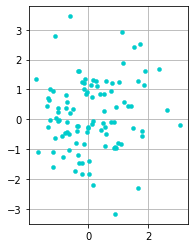

In [51]:
fig = plt.figure()
ax = fig.add_subplot()
ax.grid()
ax.set_aspect('equal')
ax.plot(points[0], points[1], "o", color="#00cccc", ms=4, mew=0.5)
plt.show()

In [27]:
mu = points.mean(axis = 1).reshape([2,1])
cov = points.dot(points.transpose()) / n
cov_inv = np.linalg.inv(cov)
mu = np.zeros([2,1]) #今回は母集団の平均とする

In [28]:
ds = points - mu
points_inlier = np.empty((2,0))
points_outlier = np.empty((2,0))
for i in range(ds.shape[1]):
    d = ds[:,i].reshape([2,1])
    chi = d.transpose().dot(cov_inv).dot(d)
    if(chi > chi2):
        #print("outlier", chi)
        points_outlier = np.append(points_outlier, d, axis=1)
    else:
        #print("inlier", chi)
        points_inlier = np.append(points_inlier, d, axis=1)

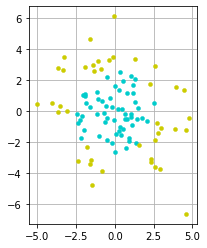

In [52]:
fig = plt.figure()
ax = fig.add_subplot()
ax.grid()
ax.set_aspect('equal')
ax.plot(points_inlier[0], points_inlier[1], "o", color="#00cccc", ms=4, mew=0.5)
ax.plot(points_outlier[0], points_outlier[1], "o", color="#cccc00", ms=4, mew=0.5)
plt.show()

In [53]:
points_test = np.random.randn(2, 100) * 2
ds = points_test - mu
points_inlier = np.empty((2,0))
points_outlier = np.empty((2,0))
for i in range(ds.shape[1]):
    d = ds[:,i].reshape([2,1])
    chi = d.transpose().dot(cov_inv).dot(d)
    if(chi > chi2):
        #print("outlier", chi)
        points_outlier = np.append(points_outlier, d, axis=1)
    else:
        #print("inlier", chi)
        points_inlier = np.append(points_inlier, d, axis=1)

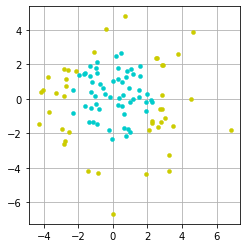

In [55]:
fig = plt.figure()
ax = fig.add_subplot()
ax.grid()
ax.set_aspect('equal')
ax.plot(points_inlier[0], points_inlier[1], "o", color="#00cccc", ms=4, mew=0.5)
ax.plot(points_outlier[0], points_outlier[1], "o", color="#cccc00", ms=4, mew=0.5)
plt.show()

In [59]:
#https://python.atelierkobato.com/ellipse/
# 楕円クラスを定義
class Ellipse:
    # 円周率の近似値をクラス変数として定義
    pi = np.pi

    # インスタンス変数の定義
    def __init__(self, a, b, center=(0,0), n=129):
        self.major_radius = a  # 長軸半径
        self.minor_radius = b  # 短軸半径
        self.center = center  # 中心点の座標
        self.f_distance = np.sqrt(a**2 - b**2)  # 原点から焦点までの距離
        
        # 右側焦点の座標と左側焦点の座標
        self.focus_1 = (self.center[0] + self.f_distance, self.center[1])
        self.focus_2 = (self.focus_1[0] - 2 * self.f_distance, self.center[1])
        
        self.eccentricity = self.f_distance / a  # 離心率
        self.area =self.pi * self.major_radius * self.minor_radius  # 面積
        self.perimeter = 4 * ellipe(self.eccentricity)  # 周の長さ
        
        t = np.linspace(0, 2*np.pi, n)
        self.x = self.center[0] + self.major_radius * np.cos(t)
        self.y = self.center[1] + self.minor_radius * np.sin(t)

    # 回転メソッド
    # angleで回転角度(ラジアン)を指定
    # r_axisで回転軸の座標を指定
    def rotate(self, angle, r_axis):

        # 回転行列
        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle),  np.cos(angle)]])

        # 焦点の回転
        p = np.array(r_axis)
        self.focus_1 = np.dot(R, self.focus_1 - p) + p
        self.focus_2 = np.dot(R, self.focus_2 - p) + p

        # 楕円の回転
        q = np.array([[r_axis[0]],[r_axis[1]]])
        arr = np.vstack((self.x, self.y))
        arr_2 = np.dot(R, arr - q) + q
        self.x = arr_2[0]
        self.y = arr_2[1]

    # データ一覧表示メソッド
    def show_data(self):
        print(" 長軸半径　{}\n".format(self.major_radius),
              "短軸半径　{}\n".format(self.minor_radius),
              "中心点　{}\n".format(self.center),
              "第1焦点　{}\n".format(self.focus_1),
              "第2焦点　{}\n".format(self.focus_2),
              "離心率　{}\n".format(self.eccentricity),
              "面積　{}\n".format(self.area),
              "弧長　{}\n".format(self.perimeter))

    # 楕円の描画メソッド
    # oval_colorで楕円の線の色を指定
    # display_focusをTrueに設定すると焦点を表示
    # display_centerをTrueに設定すると中心点を表示
    def draw(self, ax, n=129, linestyle="-", oval_color="black",
             display_focus=False, focus_color="black",
             display_center=False, center_color="black"):

        ax.plot(self.x, self.y, color=oval_color, linestyle=linestyle)

        if display_focus == True:
            ax.scatter(self.focus_1[0], self.focus_1[1], color=focus_color)
            ax.scatter(self.focus_2[0], self.focus_2[1], color=focus_color)
        
        if display_center == True:
            ax.scatter(self.center[0], self.center[1], color=center_color)

In [60]:
eigen, eigen_vector = np.linalg.eig(cov)
print(eigen)
a = np.sqrt(chi2 * eigen[np.argmax(eigen)])
b = np.sqrt(chi2 * eigen[np.argmin(eigen)])
theta = math.atan2(eigen_vector[1, np.argmax(eigen)], eigen_vector[0, np.argmax(eigen)])
print(a, b, theta)

[1.00359541 1.45522092]
2.952664648876731 2.452048147516406 -1.9128521202743294


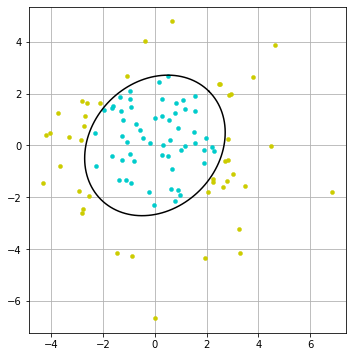

In [61]:
oval = Ellipse(a, b)
oval.rotate(np.pi/4, (0, 0))
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.grid()
ax.set_aspect('equal')
ax.plot(points_inlier[0], points_inlier[1], "o", color="#00cccc", ms=4, mew=0.5)
ax.plot(points_outlier[0], points_outlier[1], "o", color="#cccc00", ms=4, mew=0.5)
oval.draw(ax)
plt.show()